# L2P impl

# 1. Datasets
    - Split CIFAR-100 : Split to 10 tasks (10 classes per task)
    - 5-datasets : CIFAR-10, MNIST, Fashion-MNIST, SVHN, notMNIST

In [5]:
from torchvision import transforms, datasets
import torch
from urllib.request import urlretrieve
import zipfile

# dataset name, transform_train, transform_val, data_path
def get_dataset(dataset, transform_train, transform_val, data_path, download):
    if dataset == "CIFAR10":
        train = datasets.CIFAR10(data_path, train=True, download=download, transform=transform_train)
        val = datasets.CIFAR10(data_path, train=False, download=download, transform=transform_train)
    elif dataset == "CIFAR100":
        train = datasets.CIFAR100(data_path, train=True, download=download, transform=transform_train)
        val = datasets.CIFAR100(data_path, train=False, download=download, transform=transform_train)
    elif dataset == "MNIST":
        train = datasets.MNIST(data_path, train=True, download=download, transform=transform_train)
        val = datasets.MNIST(data_path, train=False, download=download, transform=transform_train)
    elif dataset == "Fashion-MNIST":
        train = datasets.FashionMNIST(data_path, train=True, download=download, transform=transform_train)
        val = datasets.FashionMNIST(data_path, train=False, download=download, transform=transform_train)
    elif dataset == "SVHN":
        train = datasets.SVHN(data_path, train=True, download=download, transform=transform_train)
        val = datasets.SVHN(data_path, train=False, download=download, transform=transform_train)
    elif dataset == "notMNIST":
        root = data_path
        if download:
            # data url
            data_url = "https://github.com/facebookresearch/Adversarial-Continual-Learning/raw/main/data/notMNIST.zip"
            zip_file_path = "{}/notMNIST.zip".format(root)
            # retrieve data 
            print("Downloading notMNIST from https://github.com/facebookresearch/Adversarial-Continual-Learning/raw/main/data/notMNIST.zip")
            path, headers = urlretrieve(data_url, zip_file_path)
            # unzip
            with zipfile.ZipFile(zip_file_path, 'r') as obj:
                obj.extractall(root)
        
        train = datasets.ImageFolder("{}/notMNIST/Train".format(root), transform=transform_train)
        val = datasets.ImageFolder("{}/notMNIST/Train".format(root), transform=transform_val)
        
    else :
        raise ValueError("{} not found".format(dataset))
    return train, val

def get_tranforms(is_train):
    # train dataset transform
    if is_train:
        return transforms.Compose([
                transforms.PILToTensor(),
                transforms.RandomResizedCrop(size=(224,224)),
                transforms.RandomHorizontalFlip(p=0.5),
            ])
    # test dataset transform
    else :
        return transforms.Compose([
            transforms.PILToTensor(),
            transforms.Resize(256),
            transforms.CenterCrop(224),
        ])

# Check datasets

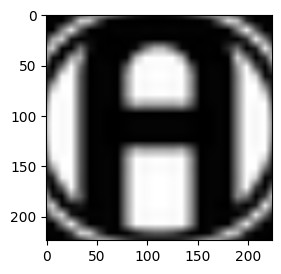

In [34]:
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt
def print_img(dataset, idx):
    img = dataset.__getitem__(idx)[0]
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(to_pil_image(img), cmap='gray')


# Model : Vision Transformer ViT-B/16


In [69]:
import torch.nn as nn

# takes an image as an input, divide it into patches, let it through the embedding layer
class PatchEmbed(nn.Module):
    def __init__(self, img_size, patch_size, in_channels=3, embed_dim=768):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.in_channels = in_channels
        self.embed_dim = embed_dim
        self.n_patches = (img_size // patch_size) ** 2
        
        self.proj = nn.Conv2d(
            in_channels,
            embed_dim,
            stride=patch_size, 
            kernel_size=patch_size
        )
        
        
    def forward(self, input):
        x = self.proj(input)               # (n, 3, 224, 224) -> (n, embed_dim, patch_size, patch_size, ) 
        x = torch.flatten(x, start_dim=2, end_dim=3)  # (n, embed_dim, patch_size*patch_size)
        x = torch.transpose(x,1,2)           # (n, patch_size*patch_size, embed_dim)
        return x

class AttentionLayer(nn.Module):
    def __init__(self, dim, qkv_bias=True):
        super.__init__()
        self.dim = dim
        self.qkv = nn.Linear(dim, dim*3, bias=qkv_bias)
        self.dropout_attn = nn.Dropout(0.)
        self.proj = nn.Linear(dim, dim)
        self.dropout_proj = nn.Dropout(0.)
        
    def forward(self, input):
        # input : (n, num_patch+1, embed_dim)
        ''' 
        [
            [  1번 이미지       
                [     1번 패치
                        embed_dim
                ]
            ],
            [   2번 이미지
                [   1번패치
                    1,2,3214,,32,63,3261,5,..
                ]
                
            ],
            ...
        ]
        '''
        num_samples, num_tokens, dim = input.shape
        if dim != self.dim :
            raise ValueError
        
        # Norm
        # multi-head attention
        qkv = self.qkv(input) # (n, num_patch+1, embed_dim * 3)
        # 위에서 q,k,v 분리해야 함
        qkv = torch.reshape(qkv, num_samples, num_tokens, 3)
        # Residual connection
        # Norm
        # MLP
        # Residual connection
        
class VisionTransformer(nn.Module):
    def __init__(self, img_size, patch_size, in_channels, embed_dim):
        self.embedding = PatchEmbed(img_size, patch_size, in_channels=in_channels, embed_dim=embed_dim)
        self.cls_token = nn.Parameter(torch.zeros(1,1,embed_dim))
        self.position_embedding
        self.attention